<a href="https://colab.research.google.com/github/william-maillard/DL_text-translation/blob/main/DeepL_Text_Translation_w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
vocab_size = 15000 # Définit le nombre total de mots distincts que le modèle peut reconnaître et générer
sequence_length = 50 # La longueur maximale des séquences (phrases ou textes) que le modèle peut traiter. a faire passer a 50
batch_size = 64 # Nombre de séquences traitées ensemble à chaque (epochs) étape d'entraînement.
embed_dim = 512 # Taille de l'espace de représentation vectorielle dans lequel les mots sont encodés. a tester avec un espace vec de 512
num_heads = 8 # Dans les mécanismes d'attention multi-têtes, cela définit combien de sous-espaces d'attention sont créés. tester avec 12 tetes
ff_dim = 2048 # Taille de la couche cachée dans les réseaux de neurones feed-forward à l'intérieur des blocs d'encodeur et de décodeur.
num_blocks = 8 # Nombre de fois que les blocs d'encodeur ou de décodeur sont répétés dans le modèle. ( peut monter jusqu'a 12) tache simple (2 a 4) a tester avec 12 blocs
rnn_units = 512   # Nombre d'unités dans les couches LSTM/GRU a tester avec 512
dropout_rate = 0.5 # est utilisée pour désactiver aléatoirement un pourcentage de neurones pendant l'entraînement, agissant ainsi comme une forme de régularisation.
latent_dim=1024 # est la taille de la couche intermédiaire entre les entrées et sorties pour transformer pour ajouter de la capacité au model (Agit comme un goulot d'étranglement pour régulariser le modèle)
epochs = 15

# Pip install

In [ ]:
# !pip install datasets
!pip install scikeras
# !python -m spacy
# !python -m download
# !python -m fr_core_news_sm
# !pip uninstall tf_keras keras
# !pip install tensorflow --upgrade

# Les Imports

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pathlib
import random
import string
import re
import seaborn as sns
# import keras
# from keras import ops
from tqdm import tqdm
from wordcloud import WordCloud
import inflect
import spacy
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, Dropout, LayerNormalization, TextVectorization, Layer, LSTM, GRU,Concatenate
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import string
# from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import pickle



# Dataset

In [ ]:
segmentation_dataset = load_dataset(
'Nicolas-BZRD/Parallel_Global_Voices_English_French',
split='train'
).to_pandas()

In [ ]:
# segmentation_dataset.head()

In [ ]:
# Function to plot sentence length distribution
def plot_sentence_length_distribution(texts, language):
    lengths = [len(sentence.split()) for sentence in texts]
    plt.hist(lengths, bins=range(101))
    plt.title(f"Sentence Length Distribution in {language}")
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Sentences')
    plt.xlim(0, 100)
    plt.show()

# Function to create a word cloud
def create_word_cloud(texts, language):
    text_combined = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Word Cloud for {language}")
    plt.show()

# Plotting for English and French
# plot_sentence_length_distribution(segmentation_dataset['en'], 'English')
# plot_sentence_length_distribution(segmentation_dataset['fr'], 'French')

# create_word_cloud(segmentation_dataset['en'], 'English')
# create_word_cloud(segmentation_dataset['fr'], 'French')

# Filter Dataset

In [ ]:
# Initialize inflect engine
p = inflect.engine()

# Load the Spacy model for French
nlp = spacy.load("fr_core_news_sm")

def number_to_words(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def has_svo_structure(sentence):
    doc = nlp(sentence)
    subjects = [tok for tok in doc if "subj" in tok.dep_]
    objects = [tok for tok in doc if "obj" in tok.dep_]
    verbs = [tok for tok in doc if tok.pos_ == "VERB"]
    return len(subjects) > 0 and len(objects) > 0 and len(verbs) > 0

def filter_dataset(dataset):
    rows_to_add = []
    for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0], desc="Processing"):
        en_sentence = number_to_words(row['en'])
        fr_sentence = number_to_words(row['fr'])
        if has_svo_structure(fr_sentence) and len(fr_sentence.split()) <= 50:
            rows_to_add.append({'en': en_sentence, 'fr': fr_sentence})

    return pd.DataFrame(rows_to_add, columns=['en', 'fr'])

# Assuming 'segmentation_dataset' is your DataFrame with columns 'en' and 'fr'
filtered_dataset = filter_dataset(segmentation_dataset)

OSError: [E050] Can't find model 'fr_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# Sauvegarde du DataFrame filtré au format Pickle dans Google Drive
filtered_dataset.to_pickle('/content/drive/MyDrive/models/filtered_dataset.pkl')

In [ ]:
# filtered_dataset.head()

In [ ]:
# Calculate sentence lengths
original_lengths_en = segmentation_dataset['en'].str.split().apply(len)
filtered_lengths_en = filtered_dataset['en'].str.split().apply(len)

original_lengths_fr = segmentation_dataset['fr'].str.split().apply(len)
filtered_lengths_fr = filtered_dataset['fr'].str.split().apply(len)

# Create histograms
def plot_length_comparison(original_lengths, filtered_lengths, language, x_range=None):
    plt.figure(figsize=(12, 6))

    # Zoom in on a specific x_range, if provided
    if x_range:
        original_lengths = [length for length in original_lengths if x_range[0] <= length <= x_range[1]]
        filtered_lengths = [length for length in filtered_lengths if x_range[0] <= length <= x_range[1]]

    plt.hist(original_lengths, color="skyblue", label='Original', bins=50, alpha=0.5)
    plt.hist(filtered_lengths, color="red", label='Filtered', bins=50, alpha=0.5)
    plt.title(f'Sentence Length Distribution Before and After Filtering in {language}')
    plt.xlabel('Sentence Length (Number of Words)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot comparison for English with zoomed-in range
plot_length_comparison(original_lengths_en, filtered_lengths_en, 'English', x_range=(0, 50))

# Plot comparison for French with zoomed-in range
plot_length_comparison(original_lengths_fr, filtered_lengths_fr, 'French', x_range=(0, 50))


In [ ]:
def plot_word_frequency_comparison(original_texts, cleaned_texts, title, language):
    # Count word frequencies in the original and cleaned datasets
    original_counter = Counter(" ".join(original_texts).split())
    cleaned_counter = Counter(" ".join(cleaned_texts).split())

    # Get the 30 most common words in each dataset
    original_common = original_counter.most_common(30)
    cleaned_common = cleaned_counter.most_common(30)

    # Separate the words and their frequencies
    original_words, original_freqs = zip(*original_common)
    cleaned_words, cleaned_freqs = zip(*cleaned_common)

    # Create a subplot for each set of word frequencies
    fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

    # Plot for the original dataset
    axes[0].barh(original_words, original_freqs, color='skyblue')
    axes[0].set_title(f'Most Common Words in {language} Before Cleaning')

    # Plot for the cleaned dataset
    axes[1].barh(cleaned_words, cleaned_freqs, color='red')
    axes[1].set_title(f'Most Common Words in {language} After Cleaning')

    # Invert y-axis for both subplots to have the most frequent words on top
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

    # Set labels
    axes[0].set_xlabel('Frequency')
    axes[1].set_xlabel('Frequency')

    # Add the main title and show the plot
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()


# Plot word frequency comparison for English
plot_word_frequency_comparison(
    segmentation_dataset['en'].tolist(),
    filtered_dataset['en'].tolist(),
    '',
    'English'
)

# Plot word frequency comparison for French
plot_word_frequency_comparison(
    segmentation_dataset['fr'].tolist(),
    filtered_dataset['fr'].tolist(),
    '',
    'French'
)

# Launch filtred dataset

In [ ]:
filtered_dataset = pd.read_pickle('/content/drive/MyDrive/models/filtered_dataset.pkl')

# Preprocessing

In [ ]:
# carte de remplacement pour les caractères accentués (français)
accents_map_french = str.maketrans(
    'àáâäãåçèéêëìíîïñòóôöõøùúûüýÿ',
    'aaaaaaceeeeiiiinoooooouuuuyy'
)

In [ ]:
def clean_text(txt, accents_map=None, lang_to_work=False):
    if accents_map:
        txt = txt.translate(accents_map)
    # Keep apostrophes and remove other punctuation
    punctuation_to_remove = string.punctuation.replace("'", "")  # Apostrophes are kept
    tiret_to_keep = string.punctuation.replace("-", "")
    txt = "".join(v for v in txt if v not in punctuation_to_remove and tiret_to_keep).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    if lang_to_work:
        txt = "[start] " + txt + " [end]"
    return txt

In [ ]:
preprocessed_dataset = pd.DataFrame()
# preprocessed_dataset['en_clean'] = segmentation_dataset['en'].apply(clean_text, args=(None,lang_to_work:=True))
# preprocessed_dataset['fr_clean'] = segmentation_dataset['fr'].apply(clean_text, args=(accents_map_french, lang_to_work:=False))
preprocessed_dataset['en_clean'] = filtered_dataset['en'].apply(clean_text, args=(None,lang_to_work:=True))
preprocessed_dataset['fr_clean'] = filtered_dataset['fr'].apply(clean_text, args=(accents_map_french, lang_to_work:=False))


In [ ]:
# preprocessed_dataset.head(100)

In [ ]:
# Mélange aléatoire des données
shuffled_data = preprocessed_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Scinder les données en ensembles d'entraînement et temp (validation + test)
train_data, temp_data = train_test_split(shuffled_data, test_size=0.3, random_state=42)

# Scinder l'ensemble temp en ensembles de validation et de test
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Afficher les tailles des ensembles pour vérifier
print("Taille de l'ensemble de la dataset:", len(shuffled_data))
print("Taille de l'ensemble d'entraînement :", len(train_data)) # 70%
print("Taille de l'ensemble de validation :", len(validation_data)) # 15%
print("Taille de l'ensemble de test :", len(test_data)) # 15%

Taille de l'ensemble de la dataset: 185442
Taille de l'ensemble d'entraînement : 129809
Taille de l'ensemble de validation : 27816
Taille de l'ensemble de test : 27817


In [ ]:
# test_data.head()

In [ ]:
def plot_dataset_splits(shuffled_data):
    train_data, temp_data = train_test_split(shuffled_data, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    sizes = [len(train_data), len(validation_data), len(test_data)]
    labels = [f'Training : {len(train_data)} sentences', f'Validation : {len(validation_data)} sentences', f'Test : { len(test_data)} sentences']

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Dataset Splits')
    plt.show()

# plot_dataset_splits(shuffled_data)

# Tokenize data

In [ ]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("'", "")  # Les apostrophes sont conservées
strip_chars = strip_chars.replace("-", "") # Les tirets sont conservés
strip_chars = strip_chars.replace("[", "")  # Les crochets ouverts sont conservés
strip_chars = strip_chars.replace("]", "")  # Les crochets fermés sont conservés



def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)

    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Création des objets de vectorisation pour le français et l'anglais
fr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization
)
# Le custom_standardization a appliquer a la langue qu'ont souhaite étudier afins de garder les balises [start] et [end]
en_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

# Adaptation des données
train_fr_texts = train_data['fr_clean'].tolist()
train_en_texts = train_data['en_clean'].tolist()

fr_vectorization.adapt(train_fr_texts)
en_vectorization.adapt(train_en_texts)

In [ ]:
print(en_vectorization.get_vocabulary())

['', '[UNK]', 'the', '[start]', '[end]', 'of', 'to', 'and', 'in', 'a', 'that', 'is', 'for', 'on', 'it', 'as', 'with', 'i', 'are', 'this', 'have', 'by', 'was', 'from', 'not', 'has', 'their', 'they', 'be', 'we', 'who', 'an', 'people', 'but', 'at', 'his', 'he', 'about', 'will', 'one', 'you', 'which', 'there', 'or', 'also', 'all', 'were', 'what', 'been', 'can', 'more', 'some', 'if', 'her', 'our', 'government', 'my', 'many', 'when', 'two', 'them', 'its', 'so', 'other', 'had', 'would', 'no', 'out', 'us', 'do', 'country', 'up', 'media', 'like', 'how', 'after', 'these', 'she', 'new', 'where', 'only', 'blog', 'those', 'even', 'because', 'time', 'now', 'against', 'world', 'me', 'first', 'than', 'into', 'just', 'such', 'political', 'most', 'over', 'being', 'should', 'thousand', 'social', 'president', 'while', 'any', 'es', 'day', 'police', 'years', 'public', 'twitter', 'women', 'news', "don't", 'said', 'way', 'post', 'see', 'him', 'hundred', "it's", 'video', 'could', 'make', 'your', 'rights', 'tak

In [ ]:
# print(fr_vectorization.get_vocabulary())

# Batch data

In [ ]:
def format_dataset(eng, fr):
    eng = en_vectorization(eng)
    fr = fr_vectorization(fr)
    return (
        {
            "encoder_inputs": fr,
            "decoder_inputs": eng[:, :-1],
        },
        eng[:, 1:],
    )
# 7483 x 32 = 239442 batch stable colab ne crash pas
# Permet d'utiliser un batch sur le dataset et evité de faire crash le collab
def make_dataset(dataframe):
    eng_texts = list(dataframe['en_clean'])
    fr_texts = list(dataframe['fr_clean'])
    # print(len(eng_texts))
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fr_texts))
    # print(len(dataset))
    dataset = dataset.batch(batch_size)
    # print(len(dataset))
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_dataset = make_dataset(train_data)
validation_dataset = make_dataset(validation_data)
test_dataset = make_dataset(test_data)


In [ ]:
# On a des batches de 64 paires, et toutes les séquences ont une longueur de 20 pas)
for inputs, targets in test_dataset.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 50)
inputs["decoder_inputs"].shape: (64, 50)
targets.shape: (64, 50)


# Construction du model sequence to sequence

In [ ]:
# class MultiHeadSelfAttention(Layer):
#     def __init__(self, embed_size, num_heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.embed_size = embed_size
#         self.num_heads = num_heads
#         assert embed_size % num_heads == 0
#         self.projection_dim = embed_size // num_heads
#         self.query_dense = Dense(embed_size)
#         self.key_dense = Dense(embed_size)
#         self.value_dense = Dense(embed_size)
#         self.combine_heads = Dense(embed_size)

#     def attention(self, query, key, value):
#         score = tf.matmul(query, key, transpose_b=True)
#         dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
#         scaled_score = score / tf.math.sqrt(dim_key)
#         weights = tf.nn.softmax(scaled_score, axis=-1)
#         output = tf.matmul(weights, value)
#         return output, weights

#     def separate_heads(self, x, batch_size):
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         query = self.query_dense(inputs)  # (batch_size, seq_len, embed_size)
#         key = self.key_dense(inputs)      # (batch_size, seq_len, embed_size)
#         value = self.value_dense(inputs)  # (batch_size, seq_len, embed_size)

#         query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
#         key = self.separate_heads(key, batch_size)      # (batch_size, num_heads, seq_len, projection_dim)
#         value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)

#         attention, _ = self.attention(query, key, value)
#         attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, projection_dim)
#         concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_size))  # (batch_size, seq_len, embed_size)
#         output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_size)
#         return output

## Les Transformers

### Encoder

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = np.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


### PositionalEmbedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = np.shape(inputs)[-1]
        positions = np.arange(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return np.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

### Decoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None, sequence_length=None):
        causal_mask = self.get_causal_attention_mask(sequence_length)

        if mask is not None:
            padding_mask = np.cast(mask[:, None, :], dtype="int32")
            padding_mask = np.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, sequence_length):
      i = np.arange(sequence_length)
      i = np.expand_dims(i, -1)

      j = np.arange(sequence_length)

      mask = np.greater_equal(i, j).astype(np.int32)
      mask = np.reshape(mask, (1, sequence_length, sequence_length))

      mult = np.concatenate([
          np.array([1]),
          np.array([1, 1])
      ], axis=0)

      mask = np.tile(mask, mult)
      return mask
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

## Build T5

In [ ]:

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, ff_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
max_seq_len = 50

x = TransformerDecoder(
    embed_dim,
    latent_dim,
    num_heads
)(
    x,
    encoded_seq_inputs,
    sequence_length=max_seq_len
)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer_adam = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer_rmsprop = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## LSTM

In [ ]:
# Define input layers
encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')

# Define embedding layers
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, name='encoder_embedding')(encoder_inputs)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, name='decoder_embedding')(decoder_inputs)

# Define the encoder LSTM
encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define MultiHeadAttention layer
multi_head_attention = MultiHeadAttention(num_heads, key_dim=embed_dim, name='multi_head_attention')
attention_output = multi_head_attention(query=decoder_embedding, value=encoder_outputs, key=encoder_outputs)

# Combine attention output with decoder inputs
decoder_combined_inputs = keras.layers.Concatenate(axis=-1)([attention_output, decoder_embedding])

# Define the decoder LSTM
decoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_lstm_outputs, _, _ = decoder_lstm(decoder_combined_inputs, initial_state=encoder_states)

# Define output layer
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_lstm_outputs)

# Define the Seq2Seq model LSTM
lstm_model_adam = Model([encoder_inputs, decoder_inputs], decoder_outputs)
lstm_model_rmsprop = Model([encoder_inputs, decoder_inputs], decoder_outputs)



## GRU

In [ ]:
# Define input layers
encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')

# Define embedding layers
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, name='encoder_embedding')(encoder_inputs)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, name='decoder_embedding')(decoder_inputs)

# Define the encoder GRU
encoder_gru = GRU(rnn_units, return_sequences=True, return_state=True, name='encoder_gru')
encoder_outputs, encoder_states = encoder_gru(encoder_embedding)

# Define MultiHeadAttention layer
multi_head_attention = MultiHeadAttention(num_heads, key_dim=embed_dim, name='multi_head_attention')
attention_output = multi_head_attention(query=decoder_embedding, value=encoder_outputs, key=encoder_outputs)

# Combine attention output with decoder inputs
decoder_combined_inputs = keras.layers.Concatenate(axis=-1)([attention_output, decoder_embedding])

# Define the decoder GRU
decoder_gru = GRU(rnn_units, return_sequences=True, return_state=True, name='decoder_gru')
decoder_gru_outputs, _ = decoder_gru(decoder_combined_inputs, initial_state=encoder_states)

# Define output layer
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_gru_outputs)

# Define the Seq2Seq model GRU
gru_model_adam = Model([encoder_inputs, decoder_inputs], decoder_outputs)
gru_model_rmsprop = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilation

In [ ]:
# Adam optimizer
optimizer_adam = Adam(learning_rate=0.001)

# RMSprop optimizer
optimizer_rmsprop = RMSprop(learning_rate=0.001)

# Sparse Categorical Crossentropy
loss_fn = SparseCategoricalCrossentropy(from_logits=False)

## Rmsprop

### LSTM

In [ ]:
# Early stopping callback to stop training after 2 epochs of no improvement in validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max', restore_best_weights=True)
# Reduce learning rate callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, verbose=1, mode='max', min_lr=0.00001)
# Add these callbacks to your training
callbacks = [early_stopping, reduce_lr]


# Compile the model
lstm_model_rmsprop.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Compile the model
# plot_model(lstm_model_rmsprop, to_file='/content/drive/MyDrive/models/Rmsprop/LSTM/model_lstm_plot_2.png', show_shapes=True, show_layer_names=True)

# lstm_model_rmsprop.summary()
lstm_history = lstm_model_rmsprop.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset
    # callbacks=callbacks
)
lstm_model_rmsprop.save('/content/drive/MyDrive/models/Rmsprop/LSTM/model_2_filtred.h5')

with open('/content/drive/MyDrive/models/Rmsprop/LSTM/lstm_history_2_filtred.pkl', 'wb') as history_file:
    pickle.dump(lstm_history.history, history_file)
# Sauvegarder l'optimizer séparément
with open('/content/drive/MyDrive/models/Rmsprop/LSTM/lstm_optimizer_2_filtred.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_rmsprop.get_config(), optimizer_file)

Epoch 1/15
2029/2029 [==============================] - 362s 176ms/step - loss: 2.9977 - accuracy: 0.5903 - val_loss: 2.7687 - val_accuracy: 0.6094
Epoch 2/15
2029/2029 [==============================] - 354s 175ms/step - loss: 2.7031 - accuracy: 0.6161 - val_loss: 2.6214 - val_accuracy: 0.6238
Epoch 3/15
2029/2029 [==============================] - 354s 175ms/step - loss: 2.5888 - accuracy: 0.6258 - val_loss: 2.5420 - val_accuracy: 0.6297
Epoch 4/15
2029/2029 [==============================] - 354s 175ms/step - loss: 2.5118 - accuracy: 0.6320 - val_loss: 2.4730 - val_accuracy: 0.6366
Epoch 5/15
2029/2029 [==============================] - 355s 175ms/step - loss: 2.4435 - accuracy: 0.6382 - val_loss: 2.4182 - val_accuracy: 0.6413
Epoch 6/15
2029/2029 [==============================] - 355s 175ms/step - loss: 2.3825 - accuracy: 0.6436 - val_loss: 2.3654 - val_accuracy: 0.6460
Epoch 7/15
2029/2029 [==============================] - 365s 180ms/step - loss: 2.3247 - accuracy: 0.6484 - val_

### GRU

In [ ]:
# Early stopping callback to stop training after 2 epochs of no improvement in validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max', restore_best_weights=True)
# Reduce learning rate callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, verbose=1, mode='max', min_lr=0.00001)
# Add these callbacks to your training
callbacks = [early_stopping, reduce_lr]
# Compile the model
gru_model_rmsprop.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Compile the model
# plot_model(gru_model_rmsprop, to_file='/content/drive/MyDrive/models/Rmsprop/GRU/model_gru_plot_2.png', show_shapes=True, show_layer_names=True)

gru_model_rmsprop.summary()
gru_history = gru_model_rmsprop.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)
gru_model_rmsprop.save('/content/drive/MyDrive/models/Rmsprop/GRU/model_2_filtred.h5')

with open('/content/drive/MyDrive/models/Rmsprop/GRU/gru_history_2_filtred.pkl', 'wb') as history_file:
    pickle.dump(gru_history.history, history_file)
# Sauvegarder l'optimizer séparément
with open('/content/drive/MyDrive/models/Rmsprop/GRU/gru_optimizer_2_filtred.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_rmsprop.get_config(), optimizer_file)

### T5

In [ ]:
# Early stopping callback to stop training after 2 epochs of no improvement in validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max', restore_best_weights=True)
# Reduce learning rate callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='max', min_lr=0.00001)
# Add these callbacks to your training
callbacks = [early_stopping, reduce_lr]

# Construire le modèle Transformer
transformer_rmsprop.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# transformer.summary()
transformer_history = transformer_rmsprop.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)
transformer_rmsprop.save('/content/drive/MyDrive/models/Rmsprop/T5/model_2_filtred.h5')

with open('/content/drive/MyDrive/models/Rmsprop/T5/transformer_history_2_filtred.pkl', 'wb') as history_file:
    pickle.dump(transformer_history.history, history_file)
# Sauvegarder l'optimizer séparément
with open('/content/drive/MyDrive/models/Rmsprop/T5/transformer_optimizer_2_filtred.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_rmsprop.get_config(), optimizer_file)

## Adam

### LSTM

In [ ]:
# Early stopping callback to stop training after 2 epochs of no improvement in validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max', restore_best_weights=True)
# Reduce learning rate callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='max', min_lr=0.00001)
# Add these callbacks to your training
callbacks = [early_stopping, reduce_lr]

# Construire le modèle Transformer
lstm_model_adam.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# transformer.summary()
lstm_history = lstm_model_adam.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)
lstm_model_adam.save('/content/drive/MyDrive/models/Adam/LSTM/model_2_filtred.h5')

with open('/content/drive/MyDrive/models/Adam/LSTM/lstm_history_2_filtred.pkl', 'wb') as history_file:
    pickle.dump(lstm_history.history, history_file)
# Sauvegarder l'optimizer séparément
with open('/content/drive/MyDrive/models/Adam/LSTM/lstm_optimizer_2_filtred.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_adam.get_config(), optimizer_file)

### GRU

In [ ]:
# Early stopping callback to stop training after 2 epochs of no improvement in validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max', restore_best_weights=True)
# Reduce learning rate callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='max', min_lr=0.00001)
# Add these callbacks to your training
callbacks = [early_stopping, reduce_lr]

# Construire le modèle Transformer
gru_model_adam.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# transformer.summary()
gru_history = gru_model_adam.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset
    # callbacks=callbacks
)
gru_model_adam.save('/content/drive/MyDrive/models/Adam/GRU/model_2_filtred.h5')

with open('/content/drive/MyDrive/models/Adam/GRU/gru_history_2_filtred.pkl', 'wb') as history_file:
    pickle.dump(gru_history.history, history_file)
# Sauvegarder l'optimizer séparément
with open('/content/drive/MyDrive/models/Adam/GRU/gru_optimizer_2_filtred.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_adam.get_config(), optimizer_file)

Epoch 1/15
2029/2029 [==============================] - 355s 171ms/step - loss: 3.5210 - accuracy: 0.5569 - val_loss: 3.0120 - val_accuracy: 0.5823
Epoch 2/15
2029/2029 [==============================] - 338s 167ms/step - loss: 2.9864 - accuracy: 0.5849 - val_loss: 2.9574 - val_accuracy: 0.5876
Epoch 3/15
2029/2029 [==============================] - 336s 166ms/step - loss: 2.9968 - accuracy: 0.5851 - val_loss: 2.9787 - val_accuracy: 0.5856
Epoch 4/15
2029/2029 [==============================] - 334s 165ms/step - loss: 3.0031 - accuracy: 0.5853 - val_loss: 3.0323 - val_accuracy: 0.5819
Epoch 5/15
2029/2029 [==============================] - 333s 164ms/step - loss: 3.1301 - accuracy: 0.5761 - val_loss: 3.0967 - val_accuracy: 0.5782
Epoch 6/15
2029/2029 [==============================] - 332s 164ms/step - loss: 3.1200 - accuracy: 0.5763 - val_loss: 3.0861 - val_accuracy: 0.5801
Epoch 7/15
2029/2029 [==============================] - 331s 163ms/step - loss: 3.0802 - accuracy: 0.5794 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### T5

In [ ]:
# Early stopping callback to stop training after 2 epochs of no improvement in validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='max', restore_best_weights=True)
# Reduce learning rate callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='max', min_lr=0.00001)
# Add these callbacks to your training
callbacks = [early_stopping, reduce_lr]

# Construire le modèle Transformer
transformer_adam.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# transformer.summary()
transformer_history = transformer_adam.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)
transformer_adam.save('/content/drive/MyDrive/models/Adam/T5/model_2_filtred.h5')

with open('/content/drive/MyDrive/models/Adam/T5/transformer_history_2_filtred.pkl', 'wb') as history_file:
    pickle.dump(transformer_history.history, history_file)
# Sauvegarder l'optimizer séparément
with open('/content/drive/MyDrive/models/Adam/T5/transformer_optimizer_2_filtred.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_adam.get_config(), optimizer_file)

Epoch 1/15
2029/2029 [==============================] - 658s 318ms/step - loss: 2.6397 - accuracy: 0.6211 - val_loss: 2.4574 - val_accuracy: 0.6336
Epoch 2/15
2029/2029 [==============================] - 644s 317ms/step - loss: 2.4081 - accuracy: 0.6396 - val_loss: 2.2937 - val_accuracy: 0.6475
Epoch 3/15
2029/2029 [==============================] - 676s 333ms/step - loss: 2.2584 - accuracy: 0.6520 - val_loss: 2.1694 - val_accuracy: 0.6591
Epoch 4/15
2029/2029 [==============================] - 644s 318ms/step - loss: 2.1182 - accuracy: 0.6644 - val_loss: 2.0552 - val_accuracy: 0.6706
Epoch 5/15
2029/2029 [==============================] - 645s 318ms/step - loss: 2.0001 - accuracy: 0.6758 - val_loss: 1.9733 - val_accuracy: 0.6795
Epoch 6/15
2029/2029 [==============================] - 645s 318ms/step - loss: 1.8947 - accuracy: 0.6871 - val_loss: 1.8996 - val_accuracy: 0.6893
Epoch 7/15
2029/2029 [==============================] - 645s 318ms/step - loss: 1.7980 - accuracy: 0.6986 - val_

# Traduction

In [ ]:
# Register the custom layer
get_custom_objects().update({"PositionalEmbedding": PositionalEmbedding})
get_custom_objects().update({"TransformerEncoder": TransformerEncoder})
get_custom_objects().update({"TransformerDecoder": TransformerDecoder})

## LSTM

In [ ]:
# model avec attention
# lstm_model_path = '/content/drive/MyDrive/models/Rmsprop/LSTM/model_2.h5'
# model avec attention + dataset filtrer
# lstm_model_path = '/content/drive/MyDrive/models/Rmsprop/LSTM/model_2_filtred.h5'

# lstm_model = load_model(lstm_model_path)


In [ ]:

en_vocab = en_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))

def translate_sentence(input_sentence, seq2seq_model):
    tokenized_input_sentence = fr_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(sequence_length):
        tokenized_target_sentence = en_vectorization([decoded_sentence])[:, :-1]
        predictions = seq2seq_model([tokenized_input_sentence, tokenized_target_sentence])

        # Use NumPy to find the argmax and convert to a concrete value
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token_index = int(sampled_token_index)
        sampled_token = en_index_lookup.get(sampled_token_index, "[end]")  # Handle unknown tokens

        if sampled_token == "[end]":
            break
        decoded_sentence += " " + sampled_token

    # Remove padding and trim the result
    decoded_sentence = decoded_sentence.replace("[start]", "").replace("[end]", "").strip()

    return decoded_sentence

# Translate and store sentences
# translated_sentences = []
# test_fr_texts = test_data['fr_clean'].tolist()[:1000]
# # for _ in range(30):
# #     input_sentence = random.choice(test_fr_texts)
# #     translated_sentence = translate_sentence(input_sentence,lstm_model)
# #     print("Input Sentence:", input_sentence)
# #     print("Translated Sentence:", translated_sentence)
# for input_sentence in tqdm(test_fr_texts, desc="Translating sentences"):
#     translated_sentence = translate_sentence(input_sentence, lstm_model)
#     translated_sentences.append(translated_sentence)
    # print("Input Sentence:", input_sentence)
    # print("Translated Sentence:", translated_sentence)


## Transformer

In [ ]:
# # model avec attention
# transformer_model_path = '/content/drive/MyDrive/models/Rmsprop/T5/model_2.h5'
# # # model avec attention + dataset filtrer
# # # transformer_model_path = '/content/drive/MyDrive/models/Rmsprop/T5/model_2_filtred.h5'
# transformer = load_model(transformer_model_path)

In [ ]:

en_vocab = en_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))

def decode_sequence(input_sentence,transformer):
    tokenized_input_sentence = fr_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(sequence_length):
        tokenized_target_sentence = en_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # Use NumPy to find the argmax and convert to a concrete value
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token_index = int(sampled_token_index)
        sampled_token = en_index_lookup[sampled_token_index]

        if sampled_token == "[end]":
            break
        decoded_sentence += " " + sampled_token


    # Remove padding and trim the result
    decoded_sentence = decoded_sentence.replace("[start]", "").replace("[end]", "").strip()

    return decoded_sentence
# Translate and store sentences
# translated_sentences = []
# test_fr_texts = test_data['fr_clean'].tolist()
# for _ in range(20):
#     input_sentence = random.choice(test_fr_texts)
#     translated = decode_sequence(input_sentence,transformer)
#     print(f"Input: {input_sentence}")
#     print(f"Translated: {translated}\n")
# for input_sentence in tqdm(test_fr_texts, desc="Translating sentences"):
#     translated_sentence = decode_sequence(input_sentence)
#     translated_sentences.append(translated_sentence)

## GRU

In [ ]:
# model avec attention
# gru_model_path = '/content/drive/MyDrive/models/Rmsprop/GRU/model_2.h5'
# model avec attention + dataset filtrer
# gru_model_path = '/content/drive/MyDrive/models/Rmsprop/GRU/model_2_filtred.h5'
# model avec attention
# gru_model_path = '/content/drive/MyDrive/models/Adam/GRU/model_2.h5'
# # model avec attention + dataset filtrer
gru_model_path = '/content/drive/MyDrive/models/Adam/GRU/model_2_filtred.h5'
gru_model = load_model(gru_model_path)


In [ ]:
en_vocab = en_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))

def translate_sentence(input_sentence, seq2seq_model):
    tokenized_input_sentence = fr_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(sequence_length):
        tokenized_target_sentence = en_vectorization([decoded_sentence])[:, :-1]
        predictions = seq2seq_model([tokenized_input_sentence, tokenized_target_sentence])

        # Use NumPy to find the argmax and convert to a concrete value
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token_index = int(sampled_token_index)
        sampled_token = en_index_lookup.get(sampled_token_index, "[end]")  # Handle unknown tokens

        if sampled_token == "[end]":
            break
        decoded_sentence += " " + sampled_token

    # Remove padding and trim the result
    decoded_sentence = decoded_sentence.replace("[start]", "").replace("[end]", "").strip()

    return decoded_sentence

# Translate and store sentences
# translated_sentences = []
test_fr_texts = test_data['fr_clean'].tolist()[:1000]
for _ in range(30):
    input_sentence = random.choice(test_fr_texts)
    translated_sentence = translate_sentence(input_sentence, gru_model)
    print("Input Sentence:", input_sentence)
    print("Translated Sentence:", translated_sentence)
# for input_sentence in tqdm(test_fr_texts, desc="Translating sentences"):
#     translated_sentence = translate_sentence(input_sentence, gru_model)
#     translated_sentences.append(translated_sentence)

Input Sentence: certains pensent qu'il n'a eu que ce qu'il meritait pour avoir continue de s'exprimer ouvertement contre l'article 112
Translated Sentence: 
Input Sentence: lee kil joon a fait un choix difficile dans sa vie
Translated Sentence: 
Input Sentence: cet atelier est une tentative d'impulser un sang neuf dans l'art egyptien de la bande dessinee en attirant les gens interesses et doues pour les aider a acquerir les outils pour caracteriser les personnages qu'ils mettent en scene
Translated Sentence: 
Input Sentence: sound of dissent a suggere que la voie la plus prudente pour le gouvernement serait de rencontrer la direction maoiste a la table de negociation et d'ouvrir le dialogue
Translated Sentence: 
Input Sentence: 6 dites que vous jouez au golf meme si ce n'est pas le cas
Translated Sentence: 
Input Sentence: le magazine britannique a fait une tres bonne evaluation de la situation au tadjikistan
Translated Sentence: 
Input Sentence: aliahkhaled les agents du niss se felic

KeyboardInterrupt: 

# Png Model


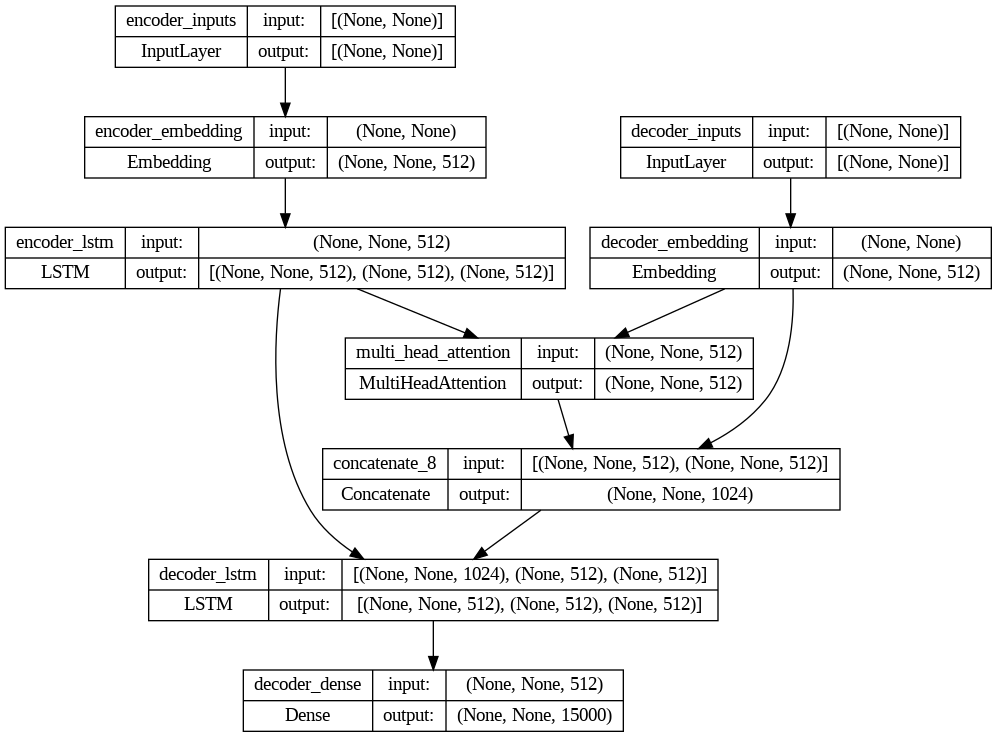

In [ ]:
plot_model(transformer_rmsprop, to_file='/content/drive/MyDrive/models/Rmsprop/T5/model_transformer_plot_vocab.png', show_shapes=True, show_layer_names=True)
plot_model(gru_model_rmsprop, to_file='/content/drive/MyDrive/models/Rmsprop/GRU/model_gru_plot_vocab.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_model_rmsprop, to_file='/content/drive/MyDrive/models/Rmsprop/LSTM/model_lstm_plot_vocab.png', show_shapes=True, show_layer_names=True)
plot_model(transformer_adam, to_file='/content/drive/MyDrive/models/Adam/T5/model_transformer_plot_vocab.png', show_shapes=True, show_layer_names=True)
plot_model(gru_model_adam, to_file='/content/drive/MyDrive/models/Adam/GRU/model_gru_plot_vocab.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_model_adam, to_file='/content/drive/MyDrive/models/Adam/LSTM/model_lstm_plot_vocab.png', show_shapes=True, show_layer_names=True)

# Evaluation

In [ ]:
def count_unk_tokens(sentences):
    return sum(sentence.count("[UNK]") for sentence in sentences)

In [ ]:
# Charger l'optimizer à partir du fichier pickle
with open('/content/drive/MyDrive/models/Adam/GRU/gru_optimizer.pkl', 'rb') as optimizer_file:
    optimizer_config = pickle.load(optimizer_file)
# Supprimer les clés obsolètes de la configuration
optimizer_config.pop('decay', None)

# Créer un nouvel optimiseur à partir de la configuration mise à jour
loaded_optimizer = tf.keras.optimizers.Adam.from_config(optimizer_config)

# Function to evaluate a model
def evaluate_model(model_path, test_dataset):
    # Load the model
    model = load_model(model_path)
    # Compile optimizer
    model.compile(optimizer=loaded_optimizer, loss=loss_fn, metrics=['accuracy'])
    # Evaluate the model on the test dataset
    loss, accuracy = model.evaluate(test_dataset)

    return loss, accuracy

# Define the model paths
lstm_model_path = '/content/drive/MyDrive/models/Adam/LSTM/model.h5'
gru_model_path = '/content/drive/MyDrive/models/Adam/GRU/model.h5'
transformer_model_path = '/content/drive/MyDrive/models/Adam/T5/model.h5'
# history the model paths
lstm_history_path = '/content/drive/MyDrive/models/Adam/LSTM/lstm_history.pkl'
gru_history_path = '/content/drive/MyDrive/models/Adam/GRU/gru_history.pkl'
transformer_history_path = '/content/drive/MyDrive/models/Adam/T5/transformer_history.pkl'

# Charger l'historique d'entraînement pour chaque modèle
with open(lstm_history_path, 'rb') as file:
    lstm_history = pickle.load(file)

with open(gru_history_path, 'rb') as file:
    gru_history = pickle.load(file)

with open(transformer_history_path, 'rb') as file:
    transformer_history = pickle.load(file)

# Test dataset
test_dataset = make_dataset(test_data)

# Evaluate each model on the test dataset and get test losses
lstm_loss, lstm_accuracy = evaluate_model(lstm_model_path, test_dataset)
gru_loss, gru_accuracy = evaluate_model(gru_model_path, test_dataset)
transformer_loss, transformer_accuracy = evaluate_model(transformer_model_path, test_dataset)



In [ ]:
# Prepare data for plotting
train_accuracies = [lstm_history['accuracy'][-1], gru_history['accuracy'][-1], transformer_history['accuracy'][-1]]
val_accuracies = [lstm_history['val_accuracy'][-1], gru_history['val_accuracy'][-1], transformer_history['val_accuracy'][-1]]
test_accuracies = [lstm_accuracy, gru_accuracy, transformer_accuracy]

bar_width = 0.25  # width of the bars
index = np.arange(3)  # three models

# Plotting
plt.figure(figsize=(12, 6))

# Training accuracy bars
train_bars = plt.bar(index, train_accuracies, bar_width, label='Training Accuracy')

# Move the index for the next set of bars
index = index + bar_width

# Validation accuracy bars
val_bars = plt.bar(index, val_accuracies, bar_width, label='Validation Accuracy')

# Move the index for the next set of bars
index = index + bar_width

# Test accuracy bars
test_bars = plt.bar(index, test_accuracies, bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy by Model')
plt.xticks(index - bar_width, ['LSTM', 'GRU', 'Transformer'])
plt.legend()

# Adding the scores on top of each bar
for bars in [train_bars, val_bars, test_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Display test losses and accuracies for each model
print(f"LSTM Test Loss: {lstm_loss}, Accuracy: {lstm_accuracy}")
print(f"GRU Test Loss: {gru_loss}, Accuracy: {gru_accuracy}")
print(f"Transformer Test Loss: {transformer_loss}, Accuracy: {transformer_accuracy}")

In [ ]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))  # 3 models, 4 metrics each
fig.suptitle('Detailed Model Performance Comparison')

# Function to plot each metric
def plot_metric(axis, history, metric, title, line_style, color):
    axis.plot(history[metric], line_style, color=color, label=metric)
    axis.set_title(title)
    axis.set_xlabel('Epoch')
    axis.set_ylabel(metric)
    axis.legend()

# LSTM plots
plot_metric(axes[0, 0], lstm_history, 'accuracy', 'LSTM Training Accuracy', 'b--', 'blue')
plot_metric(axes[0, 1], lstm_history, 'val_accuracy', 'LSTM Validation Accuracy', '--', 'orange')
plot_metric(axes[0, 2], lstm_history, 'loss', 'LSTM Training Loss', 'g--', 'green')
plot_metric(axes[0, 3], lstm_history, 'val_loss', 'LSTM Validation Loss', '--', 'red')

# GRU plots
plot_metric(axes[1, 0], gru_history, 'accuracy', 'GRU Training Accuracy', 'b--', 'blue')
plot_metric(axes[1, 1], gru_history, 'val_accuracy', 'GRU Validation Accuracy', '--', 'orange')
plot_metric(axes[1, 2], gru_history, 'loss', 'GRU Training Loss', 'g--', 'green')
plot_metric(axes[1, 3], gru_history, 'val_loss', 'GRU Validation Loss', '--', 'red')

# Transformer plots
plot_metric(axes[2, 0], transformer_history, 'accuracy', 'Transformer Training Accuracy', 'b--', 'blue')
plot_metric(axes[2, 1], transformer_history, 'val_accuracy', 'Transformer Validation Accuracy', '--', 'orange')
plot_metric(axes[2, 2], transformer_history, 'loss', 'Transformer Training Loss', 'g--', 'green')
plot_metric(axes[2, 3], transformer_history, 'val_loss', 'Transformer Validation Loss', '--', 'red')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # 3 models, 2 metrics groups each
fig.suptitle('Model Performance Comparison: Accuracy and Loss')

# Function to plot accuracy and loss metrics
def plot_metrics(axis, history, title, accuracy=True):
    if accuracy:
        # Plot accuracy and validation accuracy
        axis.plot(history['accuracy'], 'b--', label='Training Accuracy')
        axis.plot(history['val_accuracy'], 'orange', linestyle='--', label='Validation Accuracy')
        # Annotate the last point
        axis.annotate(f"{history['accuracy'][-1]:.2f}", (len(history['accuracy']) - 1, history['accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
        axis.annotate(f"{history['val_accuracy'][-1]:.2f}", (len(history['val_accuracy']) - 1, history['val_accuracy'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
    else:
        # Plot loss and validation loss
        axis.plot(history['loss'], 'g--', label='Training Loss')
        axis.plot(history['val_loss'], 'r--', label='Validation Loss')
        # Annotate the last point
        axis.annotate(f"{history['loss'][-1]:.2f}", (len(history['loss']) - 1, history['loss'][-1]), textcoords="offset points", xytext=(0,10), ha='center')
        axis.annotate(f"{history['val_loss'][-1]:.2f}", (len(history['val_loss']) - 1, history['val_loss'][-1]), textcoords="offset points", xytext=(0,10), ha='center')

    axis.set_title(title)
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Value')
    axis.legend()

# LSTM plots
plot_metrics(axes[0, 0], lstm_history, 'LSTM Accuracy (Training vs Validation)', accuracy=True)
plot_metrics(axes[0, 1], lstm_history, 'LSTM Loss (Training vs Validation)', accuracy=False)

# GRU plots
plot_metrics(axes[1, 0], gru_history, 'GRU Accuracy (Training vs Validation)', accuracy=True)
plot_metrics(axes[1, 1], gru_history, 'GRU Loss (Training vs Validation)', accuracy=False)

# Transformer plots
plot_metrics(axes[2, 0], transformer_history, 'Transformer Accuracy (Training vs Validation)', accuracy=True)
plot_metrics(axes[2, 1], transformer_history, 'Transformer Loss (Training vs Validation)', accuracy=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))  # 1 row, 2 metrics groups
fig.suptitle('Combined Model Performance Comparison')

# Function to plot accuracy for all models
def plot_accuracy(axis, lstm_history, gru_history, transformer_history):
    # LSTM accuracy
    axis.plot(lstm_history['accuracy'], 'b--', label='LSTM Training Accuracy')
    axis.plot(lstm_history['val_accuracy'], 'b:', label='LSTM Validation Accuracy')
    # GRU accuracy
    axis.plot(gru_history['accuracy'], 'g--', label='GRU Training Accuracy')
    axis.plot(gru_history['val_accuracy'], 'g:', label='GRU Validation Accuracy')
    # Transformer accuracy
    axis.plot(transformer_history['accuracy'], 'r--', label='Transformer Training Accuracy')
    axis.plot(transformer_history['val_accuracy'], 'r:', label='Transformer Validation Accuracy')

    axis.set_title('Accuracy (Training and Validation)')
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Accuracy')
    axis.legend()

# Function to plot loss for all models
def plot_loss(axis, lstm_history, gru_history, transformer_history):
    # LSTM loss
    axis.plot(lstm_history['loss'], 'b--', label='LSTM Training Loss')
    axis.plot(lstm_history['val_loss'], 'b:', label='LSTM Validation Loss')
    # GRU loss
    axis.plot(gru_history['loss'], 'g--', label='GRU Training Loss')
    axis.plot(gru_history['val_loss'], 'g:', label='GRU Validation Loss')
    # Transformer loss
    axis.plot(transformer_history['loss'], 'r--', label='Transformer Training Loss')
    axis.plot(transformer_history['val_loss'], 'r:', label='Transformer Validation Loss')

    axis.set_title('Loss (Training and Validation)')
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Loss')
    axis.legend()

# Plotting accuracy and loss for all models
plot_accuracy(axes[0], lstm_history, gru_history, transformer_history)
plot_loss(axes[1], lstm_history, gru_history, transformer_history)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Score

In [ ]:
def count_unk_tokens(translated_sentences):
    unk_counts = [sentence.count('[UNK]') for sentence in translated_sentences]
    total_unk_count = sum(unk_counts)
    return total_unk_count


In [ ]:
# Sélectionner aléatoirement 50 échantillons de l'ensemble de test
reduced_test_data = test_data.sample(n=50, random_state=42)  # 'n' est le nombre d'échantillons à sélectionner

### LSTM

In [ ]:
lstm_model = load_model('/content/drive/MyDrive/models/Adam/LSTM/model_2_filtred.h5')
test_translations_lstm = [translate_sentence(txt,lstm_model) for txt in tqdm(reduced_test_data['fr_clean'].tolist(), "Translating LSTM for F1 Score")]
# Save the data using pickle
with open('/content/drive/MyDrive/models/Adam/LSTM/test_translations_lstm_filtre.pkl', 'wb') as file:
    pickle.dump(test_translations_lstm, file)


Translating LSTM for F1 Score: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


In [ ]:
lstm_model = load_model('/content/drive/MyDrive/models/Rmsprop/LSTM/model_2_filtred.h5')
test_translations_lstm = [translate_sentence(txt,lstm_model) for txt in tqdm(reduced_test_data['fr_clean'].tolist(), "Translating LSTM for F1 Score")]
# Save the data using pickle
with open('/content/drive/MyDrive/models/Rmsprop/LSTM/test_translations_lstm_filtre.pkl', 'wb') as file:
    pickle.dump(test_translations_lstm, file)


Translating LSTM for F1 Score: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


### GRU

In [ ]:
# # ############################### #
gru_model = load_model('/content/drive/MyDrive/models/Adam/GRU/model_2_filtred.h5')
test_translations_gru = [translate_sentence(txt,gru_model) for txt in tqdm(reduced_test_data['fr_clean'].tolist(), "Translating GRU for F1 Score")]
# Save the data using pickle
with open('/content/drive/MyDrive/models/Adam/GRU/test_translations_gru_filtre.pkl', 'wb') as file:
    pickle.dump(test_translations_gru, file)


Translating GRU for F1 Score: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


In [ ]:
# # ############################### #
gru_model = load_model('/content/drive/MyDrive/models/Rmsprop/GRU/model_2_filtred.h5')
test_translations_gru = [translate_sentence(txt,gru_model) for txt in tqdm(reduced_test_data['fr_clean'].tolist(), "Translating GRU for F1 Score")]
# Save the data using pickle
with open('/content/drive/MyDrive/models/Rmsprop/GRU/test_translations_gru_filtre.pkl', 'wb') as file:
    pickle.dump(test_translations_gru, file)

OSError: No file or directory found at /content/drive/MyDrive/models/Rmsprop/GRU/model_2_filtred.h5

### T5

In [ ]:
# ############################### #
transformer = load_model('/content/drive/MyDrive/models/Adam/T5/model_2_filtred.h5')
test_translations_transformer = [decode_sequence(txt,transformer) for txt in tqdm(reduced_test_data['fr_clean'].tolist(), "Translating for F1 Score")]
# Save the data using pickle
with open('/content/drive/MyDrive/models/Adam/T5/test_translations_transformer_filtre.pkl', 'wb') as file:
    pickle.dump(test_translations_transformer, file)


Translating for F1 Score: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


In [ ]:
# ############################### #
transformer = load_model('/content/drive/MyDrive/models/Rmsprop/T5/model_2_filtred.h5')
test_translations_transformer = [decode_sequence(txt,transformer) for txt in tqdm(reduced_test_data['fr_clean'].tolist(), "Translating for F1 Score")]
# Save the data using pickle
with open('/content/drive/MyDrive/models/Rmsprop/T5/test_translations_transformer_filtre.pkl', 'wb') as file:
    pickle.dump(test_translations_transformer, file)

## Unknow values

version 1 sans filtre tous premier models qu'ont a fait spec :
- embed_dim 256
- latent 512
- epoch 10
- vocab size 15000
- sentence length 20

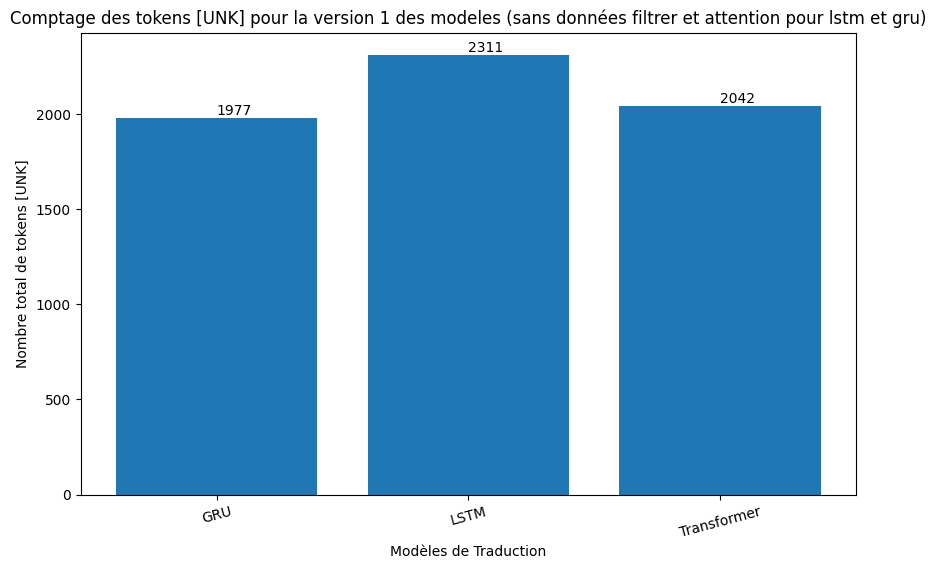

In [ ]:
# Load translated sentences from pickle files
with open('/content/drive/MyDrive/models/Adam/T5/test_translations_transformer.pkl', 'rb') as file:
    test_translations_transformer = pickle.load(file)
with open('/content/drive/MyDrive/models/Adam/LSTM/test_translations_lstm.pkl', 'rb') as file:
    test_translations_lstm = pickle.load(file)
with open('/content/drive/MyDrive/models/Adam/GRU/test_translations_gru.pkl', 'rb') as file:
    test_translations_gru = pickle.load(file)
# Comptage des tokens [UNK] pour chaque modèle
counts_adam_old = [
    count_unk_tokens(test_translations_gru),
    count_unk_tokens(test_translations_lstm),
    count_unk_tokens(test_translations_transformer)
]

labels_adam_old = ['GRU', 'LSTM', 'Transformer']

# Création du graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(labels_adam_old, counts_adam_old)
plt.xlabel('Modèles de Traduction')
plt.ylabel('Nombre total de tokens [UNK]')
plt.title('Comptage des tokens [UNK] pour la version 1 des modeles (Adam)')
# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xticks(rotation=15)
plt.show()

version 2 avec l'attention appliquer au lstm et gru meme spec :
- embed_dim 256
- latent 512
- epoch 20
- vocab size 15000
- sentence length 20

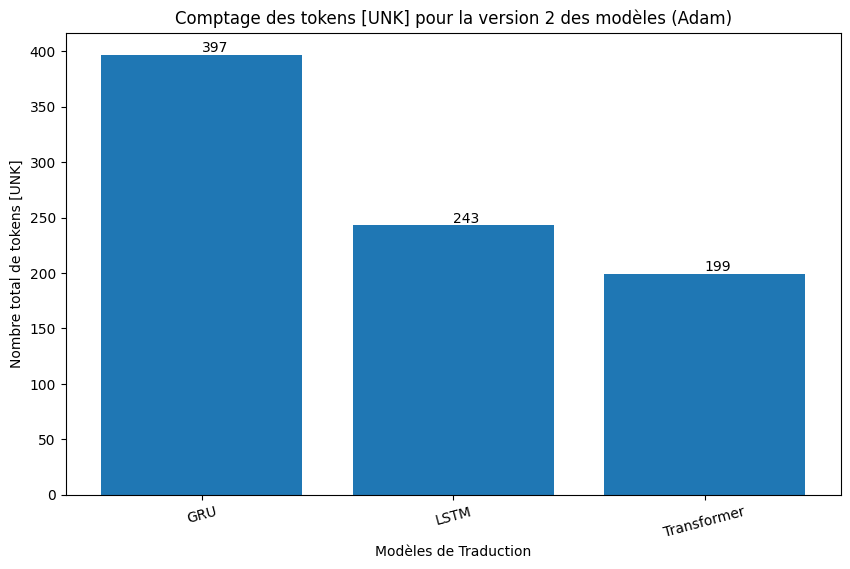

In [ ]:
# Load translated sentences from pickle files
with open('/content/drive/MyDrive/models/Adam/T5/test_translations_transformer_adam.pkl', 'rb') as file:
    test_translations_transformer_v2 = pickle.load(file)
with open('/content/drive/MyDrive/models/Adam/LSTM/test_translations_lstm_adam.pkl', 'rb') as file:
    test_translations_lstm_v2 = pickle.load(file)
with open('/content/drive/MyDrive/models/Adam/GRU/test_translations_gru_adam.pkl', 'rb') as file:
    test_translations_gru_v2 = pickle.load(file)
# Comptage des tokens [UNK] pour chaque modèle
counts_adam_old = [
    count_unk_tokens(test_translations_gru_v2),
    count_unk_tokens(test_translations_lstm_v2),
    count_unk_tokens(test_translations_transformer_v2)
]

labels_adam_old = ['GRU', 'LSTM', 'Transformer']

# Creating the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels_adam_old, counts_adam_old)
plt.xlabel('Modèles de Traduction')
plt.ylabel('Nombre total de tokens [UNK]')
plt.title('Comptage des tokens [UNK] pour la version 2 des modèles (Adam)')

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xticks(rotation=15)
plt.show()


version 3 avec données filtrer spec:
- embed dim 512
- latent 1024
- epoch 20
- vocab size 15000
- sentences length 50

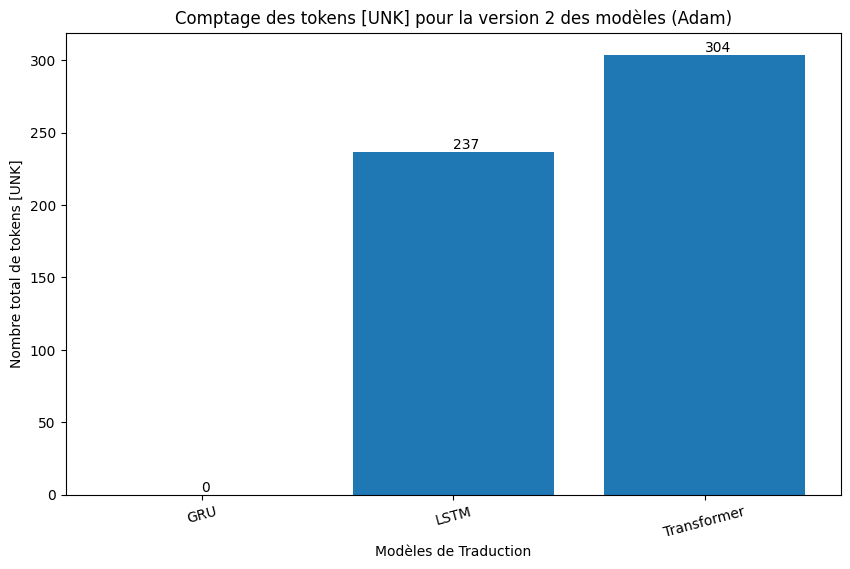

In [ ]:
# Load translated sentences from pickle files
with open('/content/drive/MyDrive/models/Adam/T5/test_translations_transformer_filtre.pkl', 'rb') as file:
    test_translations_transformer_v3 = pickle.load(file)
with open('/content/drive/MyDrive/models/Rmsprop/LSTM/test_translations_lstm_filtre.pkl', 'rb') as file:
    test_translations_lstm_v3 = pickle.load(file)
with open('/content/drive/MyDrive/models/Adam/GRU/test_translations_gru_filtre.pkl', 'rb') as file:
    test_translations_gru_v3 = pickle.load(file)
# Comptage des tokens [UNK] pour chaque modèle
counts = [
    count_unk_tokens(test_translations_gru_v3),
    count_unk_tokens(test_translations_lstm_v3),
    count_unk_tokens(test_translations_transformer_v3)
]

labels = ['GRU', 'LSTM', 'Transformer']

# Creating the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts)
plt.xlabel('Modèles de Traduction')
plt.ylabel('Nombre total de tokens [UNK]')
plt.title('Comptage des tokens [UNK] pour la version 2 des modèles (Adam)')

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xticks(rotation=15)
plt.show()


## score

In [ ]:
# ############################### #
# Convertir les textes anglais réels et les traductions en séquences de tokens
true_sequences = [en_vectorization([txt])[0].numpy() for txt in tqdm(reduced_test_data['en_clean'].tolist(), "EN vectorization")]
# Convert the translations to sequences of tokens
predicted_sequences_lstm = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_lstm, "Predicting LSTM")]
predicted_sequences_gru = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_gru, "Predicting GRU")]
predicted_sequences_transformer = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_transformer, "Predicting Transformer")]

predicted_sequences_lstm_v2 = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_lstm_v2, "Predicting LSTM")]
predicted_sequences_gru_v2 = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_gru_v2, "Predicting GRU")]
predicted_sequences_transformer_v2 = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_transformer_v2, "Predicting Transformer")]

predicted_sequences_lstm_v3 = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_lstm_v3, "Predicting LSTM")]
predicted_sequences_gru_v3 = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_gru_v3, "Predicting GRU")]
predicted_sequences_transformer_v3 = [en_vectorization([txt])[0].numpy() for txt in tqdm(test_translations_transformer_v3, "Predicting Transformer")]

In [ ]:
def jaccard_similarity(set1, set2):
    """Calculate the Jaccard Similarity between two sets."""
    intersection = len(set(set1).intersection(set2))
    union = len(set(set1).union(set2))
    return intersection / union if union != 0 else 0

# Calculate Jaccard Similarity for each model
jaccard_lstm = [jaccard_similarity(true_seq, pred_seq) for true_seq, pred_seq in zip(true_sequences, predicted_sequences_lstm)]
jaccard_gru = [jaccard_similarity(true_seq, pred_seq) for true_seq, pred_seq in zip(true_sequences, predicted_sequences_gru)]
jaccard_transformer = [jaccard_similarity(true_seq, pred_seq) for true_seq, pred_seq in zip(true_sequences, predicted_sequences_transformer)]


# Calculating the average Jaccard similarity for each model
avg_jaccard_lstm = np.mean(jaccard_lstm)
avg_jaccard_gru = np.mean(jaccard_gru)
avg_jaccard_transformer = np.mean(jaccard_transformer)

# Plotting
plt.figure(figsize=(8, 6))
models = ['LSTM', 'GRU', 'Transformer']
avg_similarities = [avg_jaccard_lstm, avg_jaccard_gru, avg_jaccard_transformer]

plt.bar(models, avg_similarities, color=['blue', 'green', 'red'])

plt.xlabel('Model')
plt.ylabel('Average Jaccard Similarity')
plt.title('Average Jaccard Similarity Comparison Across Models')
plt.ylim([0, 1])  # Jaccard similarity ranges from 0 to 1

plt.show()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Calculate BLEU scores for each model
references = [[ref.split()] for ref in reduced_test_data['en_clean'].tolist()]

candidates_lstm = [trans.split() for trans in test_translations_lstm]
candidates_gru = [trans.split() for trans in test_translations_gru]
candidates_transformer = [trans.split() for trans in test_translations_transformer]

bleu_score_lstm = corpus_bleu(references, candidates_lstm)
bleu_score_gru = corpus_bleu(references, candidates_gru)
bleu_score_transformer = corpus_bleu(references, candidates_transformer)

# Plot bar chart
model_names = ['LSTM', 'GRU', 'Transformer']
bleu_scores = [bleu_score_lstm, bleu_score_gru, bleu_score_transformer]

plt.figure(figsize=(10, 6))
plt.bar(model_names, bleu_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('BLEU Score')
plt.title('BLEU Score for Different Models')

for i, score in enumerate(bleu_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12, color='black')

plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
